<center><h1>  </h1></center>
<center><h1> IFT-6758  </h1></center>
<center><h1> Science des donn√©es</h1></center>
<center><h2> Automne - 2023 </h2></center>
<center><h3> Devoir 7 </h3></center>
<center><h3> </h3></center>

Date limite :  **Le 14 d√©c, 23h59 HAE** sur [Gradescope](https://www.gradescope.ca/courses/11400/assignments/67115/) sous forme de .ipynb

Total de points = 50

**N'IMPORTEZ RIEN D'AUTRE DES BIBLIOTH√àQUES DE CEUX-CI DONN√âES**

Ceci est important pour ex√©cuter votre code!

In [41]:
#@title Importations (Ex√©cuter d'abord cette cellule) { run: "auto" }

!pip install datasets

# imports here

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from datasets import load_dataset

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#Configuring the plot size
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Remarque**:

Nous utiliserons la biblioth√®que Keras: [https://keras.io/about/](https://keras.io/about/) pour diverses fonctions, et elle utilise le backend Tensorflow par d√©faut.
Veuillez vous assurer d'utiliser Tensorflow `2.0` ou sup√©rieur si vous ex√©cutez ce notebook localement.
Sur Google Colab, il est par d√©faut `2.14.0` normalement et vous ne devriez pas avoir de probl√®me.

## Sommaire

Ce devoir vise √† utiliser quelques id√©es fondamentales en mod√©lisation de s√©ries chronologiques en Python, d√©montrant comment appliquer ces mod√®les √† des donn√©es du monde r√©el.

Il y a 5 t√¢ches au total comprenant des questions sous chacune d'elles.


* T√¢ches 1, 2, 3 : Vous n'avez qu'√† remplir le code manquant marqu√© comme `#Student TODO`
* Les t√¢ches 4 et 5 sont exactement identiques et n√©cessitent d'appeler les fonctions impl√©ment√©es pour deux jeux de donn√©es diff√©rents avec des configurations appropri√©es dans un objet de dictionnaire, de visualiser les r√©sultats et de les interpr√©ter.


--------

- Veuillez vous assurer d'ex√©cuter les cellules dans l'ordre, car les fonctions et les variables utilis√©es pourraient provenir des cellules pr√©c√©dentes.
- Avant la soumission, veuillez ex√©cuter toutes les cellules dans l'ordre (de haut en bas) et conserver les sorties.



Dans la pr√©vision de s√©ries chronologiques ci-dessous, nous allons entra√Æner trois types de mod√®les :

1. **Mod√®les lin√©aires**: Ces mod√®les supposent une relation lin√©aire entre les donn√©es de s√©ries chronologiques et les pr√©dicteurs.

2. **Mod√®les autor√©gressifs lin√©aires**: Ces mod√®les prolongent les mod√®les lin√©aires en int√©grant les valeurs pass√©es de la s√©rie chronologique comme pr√©dicteurs. Cette approche est particuli√®rement efficace pour capturer la 'm√©moire' de la s√©rie chronologique.

3. **Mod√®le autor√©gressif non lin√©aire** (p-i√®me ordre) : Ces mod√®les sont un pas en avant, permettant de mod√©liser des relations plus complexes et non lin√©aires dans les donn√©es. Le 'p-i√®me ordre' fait r√©f√©rence au nombre d'observations d√©cal√©es utilis√©es en entr√©e.

#Fonctions d'aide au pr√©traitement des donn√©es

**Pr√©paration des donn√©es : fonctions d'aide**

Avant de se lancer dans la construction de mod√®les, il est essentiel de pr√©traiter les donn√©es. Un pr√©traitement adapt√© permet d'am√©liorer consid√©rablement les performances et la pr√©cision du mod√®le.

Explorons les √©tapes de pr√©traitement mises en ≈ìuvre dans le code ci-dessous:

1. **`standardize_features`**:
   - Cette fonction normalise les caract√©ristiques d'un ensemble de donn√©es.
   - Elle prend un tableau NumPy `X` o√π les lignes repr√©sentent des √©chantillons et les colonnes repr√©sentent des caract√©ristiques. La fonction normalise chaque caract√©ristique en soustrayant sa moyenne, puis en la divisant par son √©cart-type. Ce processus garantit que chaque caract√©ristique a une moyenne de 0 et un √©cart-type de 1, ce qui est une exigence courante pour de nombreux algorithmes d'apprentissage automatique.
   - Elle retourne l'ensemble de donn√©es normalis√©.

2. **`preprocess_dataset`**:
   - Cette fonction pr√©traite un ensemble de donn√©es chronologiques pour le pr√©parer √† des t√¢ches de pr√©diction.
   - Processus :
     - Elle localise d'abord la colonne cible dans le cadre de donn√©es `df`.
     - Convertit le cadre de donn√©es en tableau NumPy et applique quelques √©tapes de pr√©traitement, telles que le remplissage des valeurs NaN et la suppression de certaines colonnes en fonction de crit√®res sp√©cifiques (par exemple, trop de z√©ros ou de NaNs).
     - La colonne cible est ensuite isol√©e et la fonction `standardiser_features` est appliqu√©e √† cette colonne.
   - Elle retourne l'ensemble de donn√©es pr√©trait√©es et normalis√©es pr√™tes √† √™tre utilis√©es dans la mod√©lisation de s√©ries chronologiques.

3. **`prepare_dataloaders`**:
   - Cette fonction pr√©pare des chargeurs de donn√©es pour l'entra√Ænement, la validation et les tests d'un mod√®le utilisant des donn√©es chronologiques.
   - Processus :
     - Elle cr√©e d'abord des s√©quences cible en faisant rouler le tableau `data`.
     - Les donn√©es sont ensuite divis√©es en ensembles d'entra√Ænement, de validation et de test.
     - Pour chacun de ces ensembles, un `TimeseriesGenerator` est cr√©√©, qui est un utilitaire de Keras utilis√© pour transformer automatiquement une s√©quence en lots de donn√©es temporelles.
     - La fonction prend des param√®tres suppl√©mentaires √† partir de `kwargs` comme `window_size` et `batch_size` pour d√©terminer la taille des s√©quences d'entr√©e et de sortie et le nombre d'√©chantillons par lot.
   - Elle retourne trois objets `TimeseriesGenerator` pour l'entra√Ænement, la validation et les tests. Ceux-ci sont utilis√©s pour alimenter les donn√©es dans les mod√®les dans un format adapt√© √† la pr√©vision de s√©ries chronologiques.

In [3]:
def standardize_features(X):
    """
    X: array of shape (num_samples, num_features)
    """
    X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
    return X


def preprocess_dataset(df, target, lookback=1, offset=1, drop_features=[]):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, rows are samples (timesteps)
        columns are features. target is index of the target feature
        lookback: Size of window for prediction. Default=1, aka. only using the x_{t-1} to predict x_t
    """
    target = df.columns.get_loc(target) - offset #Offset to locate the correct target column
    np_data = np.asarray(df)[:, offset:].astype(np.float32)
    drop_cols = np.where(np.isnan(np_data).sum(0) == len(np_data))[0] + 1
    np_data = np.nan_to_num(np_data, nan=1e-8)
    drop_cols = np.unique(np.concatenate( ([0, target], drop_cols, np.where((np_data == 0).sum(0) == len(np_data))[0] + 1) ))
    keep_cols = np.setdiff1d(np.arange(np_data.shape[1]), drop_cols)
    np_data = np_data[:, target] # keep_cols
    dataset = standardize_features(np_data)
    print(dataset.shape, dataset.mean(0), dataset.std(0))
    return dataset

def prepare_dataloaders(data, kwargs):

    # window data
    targets = np.roll(data, shift=1, axis=0)
    targets[-1] = 0

    # Assuming 'data' and 'targets' are your input and target sequences
    train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, shuffle=False, random_state=42)
    train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.1, shuffle=False, random_state=42)

    # Create TimeseriesGenerators for training, validation, and test sets
    train_generator = TimeseriesGenerator(train_data, train_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    val_generator = TimeseriesGenerator(val_data, val_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])
    test_generator = TimeseriesGenerator(test_data, test_targets, length=kwargs['window_size'], batch_size=kwargs['batch_size'])

    return train_generator, val_generator, test_generator


## ‚úÖ **T√¢che 1 : Cr√©er des baselines**

Nous allons maintenant impl√©menter des classes pour les baselines qui produisent soit la derni√®re valeur soit la moyenne en fonction du type de baseline. Ce mod√®le ne sera pas entra√Æn√© ni optimis√© car il n'a pas de param√®tres r√©els, il nous fournit simplement une limite inf√©rieure de la performance que nous pouvons obtenir.

[2 points]

### üìå Q1.1 Baseline Mean: Implementation

Voici la traduction de la section :

`BaselineMean` produit la moyenne de la s√©rie $x$ comme pr√©diction.

Compl√©tez la m√©thode `predict()` pour y parvenir.

In [4]:
class BaselineMean(object):
    def __init__(self):
        super(BaselineMean, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###

        # Calculer la moyenne de la s√©rie
        valeur_moyenne = np.mean(x, axis=0)

        # Cr√©er un tableau de sortie avec la m√™me forme que l'entr√©e rempli de la valeur moyenne
        out = np.full_like(x, valeur_moyenne)

        ### Student TODO END###
        return out

[2 points]

### üìå Q1.2 Baseline Last: Implementation


`BaselineLast` ne produit que la derni√®re valeur $x_{t-1}$ de la s√©rie $x$.

Compl√©tez la m√©thode `predict()` pour y parvenir.

In [5]:
class BaselineLast(object):
    def __init__(self):
        super(BaselineLast, self).__init__()

    def predict(self, x):
        """
        (x_{t-1}, *) -> (x_t, *)
        """
        if x.ndim == 1:
            x = np.reshape(x, (x.shape[0], 1))

        ### Student TODO START###

        # Prendre la derni√®re valeur de x
        derniere_valeur = x[-1]

        # Cr√©er un tableau de sortie rempli avec la derni√®re valeur de x
        out = np.full((x.shape[0], x.shape[1]), derniere_valeur)

        ### Student TODO END###

        return out

## ‚úÖ **T√¢che 2 : Cr√©er un mod√®le autor√©gressif lin√©aire**



Remarquez que nos mod√®les de base ne tiennent pas compte des entr√©es pr√©c√©dentes ('m√©moire') pour faire des pr√©visions sur l'avenir. Ils ne sont pas autor√©gressifs.

Maintenant, cr√©ons deux mod√®les autor√©gressifs (AR) diff√©rents qui font des pr√©dictions en fonction des entr√©es pass√©es. Le premier mod√®le sera un mod√®le lin√©aire et le second sera un mod√®le non lin√©aire qui est un r√©seau MLP avec une non-lin√©arit√© ReLU dans sa seule couche cach√©e.

Votre t√¢che consiste √† configurer les couches de ces mod√®les pour les pr√©visions √† l'aide de la biblioth√®que Keras.

Le param√®tre `kwargs` fait r√©f√©rence √† des arguments de mot-cl√© qui sont un dictionnaire avec toutes les valeurs n√©cessaires pour configurer et entra√Æner les mod√®les.
Supposez que vous ayez acc√®s √† la taille de la fen√™tre de la s√©rie chronologique d'entr√©e en utilisant la cl√© `window_size` du dictionnaire `kwargs` et √† la taille cach√©e de l'MLP en utilisant la cl√© `mlp_dim`.

[4 points]

### üìå Q2.1 D√©finir le mod√®le autor√©gressif lin√©aire



Ajoutez les couches du mod√®le lin√©aire dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/)

In [6]:
def ar_linear(kwargs):
    model = None
    #Student TODO START

    window_size = kwargs.get('window_size', 1)
    model = Sequential()
    # Couche cach√©e avec la fonction d'activation lineaire
    model.add(Dense(units=1, input_dim=window_size, activation='linear'))

    #Student TODO END
    return model

[4 points]

### üìå Q2.3 D√©finir le mod√®le autor√©gressif MLP (nonlin√©aire)



Ajoutez les couches cach√©e et de sortie du mod√®le MLP dans Keras. Consultez le [lien](https://keras.io/guides/sequential_model/) :
* Il n'y a qu'une seule couche cach√©e et elle utilise une non-lin√©arit√© ReLU.
* La taille de la couche cach√©e peut √™tre d√©duite de la valeur `mlp_dim` du dictionnaire `kwargs`.
* La couche de sortie est la pr√©diction du mod√®le.

In [7]:
def ar_mlp(kwargs):
    model = None
    hidden_size = kwargs['mlp_dim']

    #Student TODO START
    window_size = kwargs.get('window_size', 1)
    model = Sequential()

    # Couche cach√©e avec la fonction d'activation ReLU
    model.add(Dense(units=hidden_size, input_dim=window_size, activation='relu'))


    # Couche de sortie pour effectuer la pr√©diction
    model.add(Dense(units=1, activation='linear'))


    #Student TODO END
    return model

### Fonctions d'aide aux mod√®les


In [8]:
# helper functions
def create_baseline_model(kwargs):
    if kwargs['model_name'] == 'baseline-mean':
        model = BaselineMean()
    elif kwargs['model_name'] == 'baseline-last':
        model = BaselineLast()
    return model

def create_ar_model(kwargs):
    if kwargs['model_name'] == 'ar-linear':
        model = ar_linear(kwargs)
    elif kwargs['model_name'] == 'ar-mlp':
        model = ar_mlp(kwargs)
    else:
        raise NotImplementedError
    return model

def create_model(kwargs):
    if 'baseline' in kwargs['model_name']:
        return create_baseline_model(kwargs)
    else:
        return create_ar_model(kwargs)

## üìå ü•á (Bonus) D√©finir des mod√®les pour le cas sp√©cial (MA) avec ARIMA

*[4 points]

Le mod√®le ARIMA pourrait √™tre utilis√© pour adapter un mod√®le de Moyenne Mobile (MA) : (voir https://otexts.com/fpp2/MA.html) $\varepsilon_t = \sum_{j=0}^\infty (-\theta)^j y_{t-j}.$

√âcrivez le code pour ajuster un tel mod√®le.


In [60]:
from statsmodels.tsa.arima.model import ARIMA

#STUDENT TODO OPTIONAL
def fit_arima_model(data, p, d, q):
    model = ARIMA(data, order=(p,d,q))
    model_fit = model.fit()
    return model_fit

# p est le nombre de termes autor√©gressifs
# d est le nombre de diff√©rences non saisonni√®res n√©cessaires pour obtenir une s√©rie stationnaire
# q est le nombre de termes d'erreurs de pr√©vision retard√©s dans l'√©quation de pr√©diction (termes de moyenne mobile)

# M√©triques d'√©valuation

Nous utiliserons les m√©triques suivantes:

* Erreur absolue moyenne (MAE)
* Erreur quadratique moyenne (MSE)

# Fonctions d'aide √† l'entra√Ænement et √† l'√©valuation

## ‚úÖ **T√¢che 3 : D√©finir la fonction pour l'entra√Ænement et l'√©valuation**

[12 points]

### üìå Q3. Compl√©tez la fonction `hyperparameter_sweep` pour l'entra√Ænement et l'optimisation des hyperparam√®tres :

R√©f√©rez-vous √† la documentation Keras appropri√©e dans le lien link: [https://keras.io/api/models/model_training_apis/](https://keras.io/api/models/model_training_apis/).

* Pour l'entra√Ænement du mod√®le, utilisez l'optimiseur Adam et la perte MSE avec `model.compile`.
* Utilisez `model.evaluate` sur le `val_generator` pour obtenir les m√©triques de validation.
* Gardez une trace des r√©sultats de toutes les configurations et renvoyez la `best_mse` et la `best_window_size`.

In [10]:
def hyperparameter_sweep(df, cfg):

    # Perform hyperparameter sweep for window_size
    best_mse = float('inf')
    best_window_size = None

    for window_size in cfg['hp_values']:
        cfg[cfg['hp_name']] = window_size
        data = preprocess_dataset(df, cfg['target'], lookback=cfg['window_size'])
        train_generator, val_generator, test_generator = prepare_dataloaders(data, cfg)
        model = None

        ### Student TODO START###
        def calculate_mse_for_baseline_model(model, generator):
          predictions = []
          actuals = []
          # Parcourir le g√©n√©rateur de validation pour obtenir les pr√©dictions et les vraies valeurs
          for batch in generator:
              X, y_true = batch
              y_pred = model.predict(X)  # Pr√©dictions du mod√®le de base

              # √âtant donn√© que BaselineMean.predict renvoie un tableau avec la m√™me forme que l'entr√©e,
              # nous prenons la premi√®re colonne pour correspondre aux vraies valeurs 1D
              y_pred = y_pred[:, 0] if y_pred.ndim > 1 else y_pred

              predictions.append(y_pred)
              actuals.append(y_true)

          # Concat√©ner toutes les pr√©dictions et les vraies valeurs
          predictions = np.concatenate(predictions)
          actuals = np.concatenate(actuals)

          # Calculer le MSE
          mse = np.mean((predictions - actuals)**2)
          return mse

        # Initialiser le mod√®le
        model = create_model(cfg)

        if isinstance(model, BaselineMean) or isinstance(model, BaselineLast):
            # Pour les mod√®les de base, calculez la pr√©diction et le MSE manuellement
            # Vous devez d√©finir la logique pour calculer le MSE pour BaselineMean ou BaselineLast
            mse = calculate_mse_for_baseline_model(model, val_generator)
        else:
            # Pour les mod√®les Keras, compilez et entra√Ænez comme d'habitude
            model.compile(optimizer=Adam(learning_rate=cfg['lr']), loss='mean_squared_error')
            model.fit(train_generator, epochs=cfg['epochs'], batch_size=cfg['batch_size'], verbose=0)
            mse = model.evaluate(val_generator, batch_size=cfg['test_bs'], verbose=0)

        # Comparer le MSE obtenu avec le meilleur MSE actuel et mettre √† jour si n√©cessaire
        if mse < best_mse:
            best_mse = mse
            best_window_size = window_size

        ### Student TODO END###

    # Print the best hyperparameters and corresponding mean squared error
    print("Best Mean Squared Error: ", best_mse)
    print("Best Window Size: ", best_window_size)
    return best_mse, best_window_size

# Jeu de donn√©es 1 : Consommation d'√©nergie

C'est un jeu de donn√©es compos√© de diff√©rentes caract√©ristiques li√©es √† la consommation d'√©nergie.

## Charger les donn√©es et les visualiser

Ex√©cutez les cellules de code suivantes, qui utilisent pandas pour charger et visualiser un sous-ensemble des car√©cteristiques.

Pour les car√©cteristiques choisies, nous rassemblons l'ensemble de la s√©rie temporelle dans un graphique et un segment plus petit dans un autre graphique.

In [11]:
dataset = load_dataset("vitaliy-sharandin/energy-consumption-hourly-spain")
df = dataset['train'].to_pandas()
df

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

time  generation biomass  \
0      2015-01-01 00:00:00+01:00               447.0   
1      2015-01-01 01:00:00+01:00               449.0   
2      2015-01-01 02:00:00+01:00               448.0   
3      2015-01-01 03:00:00+01:00               438.0   
4      2015-01-01 04:00:00+01:00               428.0   
...                          ...                 ...   
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
0                                     329.0   
1                                     328.0   
2                                     323.0   
3                                     254.0   
4                                     187.0   
...                                     ...   
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
0                                     0.0                 4844.0   
1                                     0.0                 5196.0   
2                                     0.0                 4857.0   
3                                     0.0                 4314.0   
4                                     0.0                 4130.0   
...                                   ...                    ...   
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
0                              0.0                     0.0   
1                              0.0                     0.0   
2                              0.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     0.0   
...                            ...                     ...   
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
0                        0.0  ...             196.0                       0.0   
1                        0.0  ...             195.0                       0.0   
2                        0.0  ...             196.0                       0.0   
3                        0.0  ...             191.0                       0.0   
4                        0.0  ...             189.0                       0.0   
...      

<Figure size 1000x2000 with 0 Axes>

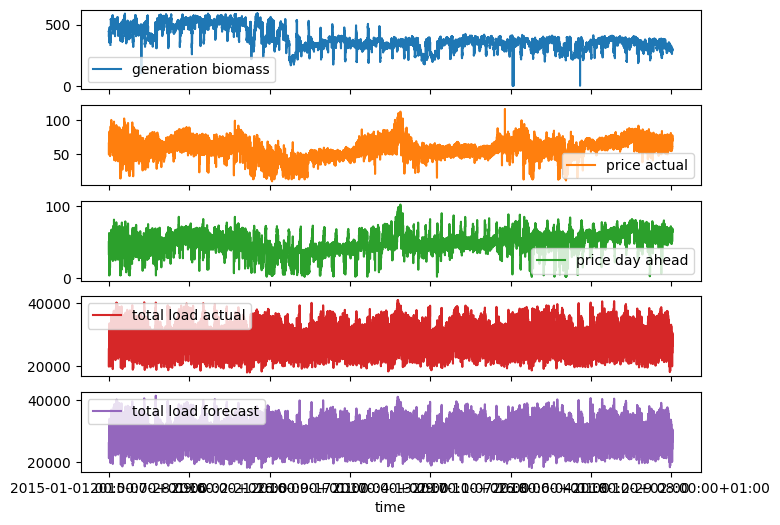

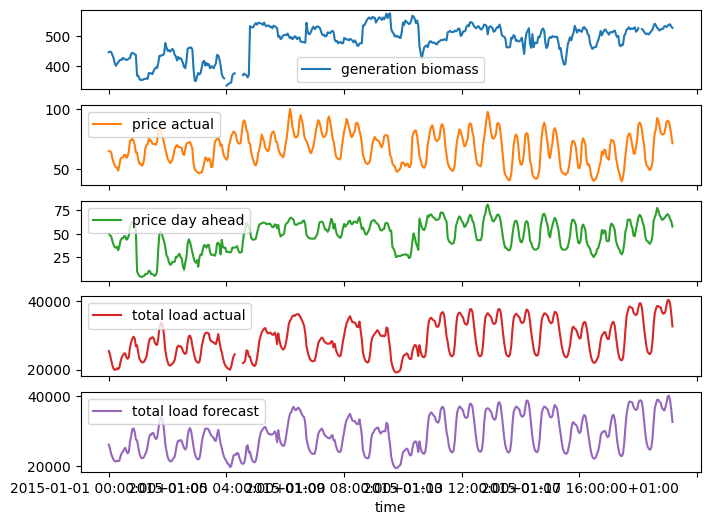

In [12]:
fig=plt.figure(figsize=(10,20))
date_time = df['time']
plot_cols = ['generation biomass', 'price actual', 'price day ahead', 'total load actual', 'total load forecast']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ‚úÖ **T√¢che 4a: √âvaluer les mod√®les de baseline**

Nous utiliserons le dictionnaire suivant pour d√©finir les configurations de la fonction `hyperparameter_sweep()` pour diff√©rents mod√®les et observer leurs performances.

In [13]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'price actual',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

[1 point]

### üìå Q4.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les r√©sultats du mod√®le de baseline de la moyenne.


In [43]:
## Student TODO ##
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

sweep_cfg['model_name'] = 'baseline-mean'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  0.6264021
Best Window Size:  8


[1 point]

### üìå Q4.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les r√©sultats du mod√®le de baseline de la derni√®re valeur (last).


In [44]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  1.3091487
Best Window Size:  16


## ‚úÖ **T√¢che 4b: Entrainer le mod√®le AR lin√©aire et r√©gler la taille de la fen√™tre**

[2 points]

### üìå Q4.3 Modifiez le dictionnaire sweep_cfg pour obtenir les r√©sultats du mod√®le AR lin√©aire et r√©gler pour le window_size optimal.

In [45]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
ARL_best_score, ARL_best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  3.1639423525575694e-08
Best Window Size:  8


## ‚úÖ **T√¢che 4c: Entrainer le mod√®le AR MLP et ajuster la taille de la fen√™tre**

[2 points]

### üìå Q4.4 Modifiez le dictionnaire sweep_cfg pour obtenir les r√©sultats du mod√®le AR MP et r√©gler pour le window_size optimal.

In [46]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-mlp'
sweep_cfg['mlp_dim'] = 10
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
(35064,) 8.355258e-08 1.0
Best Mean Squared Error:  0.0009583880892023444
Best Window Size:  8


## ‚úÖ **T√¢che 4d: Visualiser les pr√©dictions**

[3 points]

### üìå Q4.5 G√©n√©rez un graphique pour comparer visuellement les s√©ries temporelles de l'ensemble de test pr√©dites par le meilleur mod√®le et les s√©ries temporelles r√©elles.

(35064,) 8.355258e-08 1.0
219/219 [==============================] - 1s 2ms/step


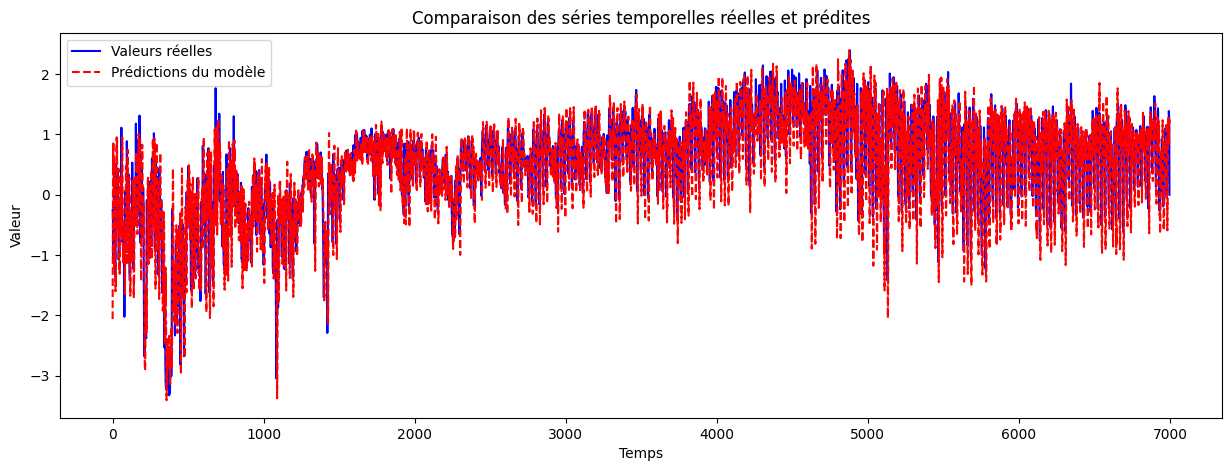

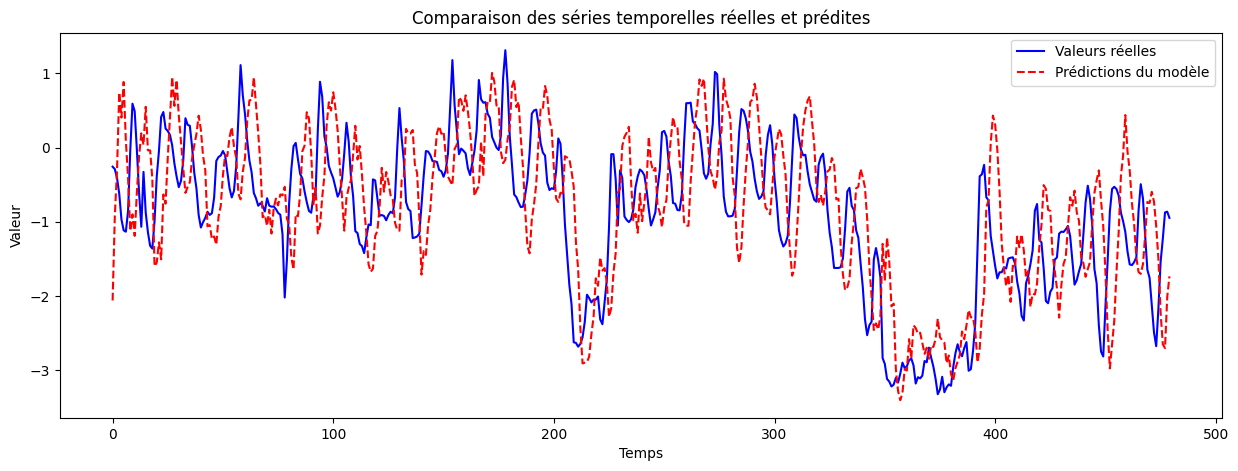

In [42]:
# Student TODO START
window_size = 16

# Pr√©traiter le jeu de donn√©es pour la meilleure taille de fen√™tre
data = preprocess_dataset(df, sweep_cfg['target'], lookback=window_size)

# D√©finir la taille de la fen√™tre dans sweep_cfg
sweep_cfg['window_size'] = window_size

# Pr√©parer les g√©n√©rateurs de donn√©es
_, _, test_generator = prepare_dataloaders(data, sweep_cfg)

# G√©n√©rer X_test et y_test en utilisant le test_generator
X_test = []
y_test = []
for batch in test_generator:
    X, y = batch
    X_test.append(X)
    y_test.append(y)

# Concat√©ner les r√©sultats si X_test et y_test sont des listes de batchs
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)



# Charger le meilleur mod√®le ar-linear avec les param√®tres optimis√©s
best_model = ar_linear({'window_size': ARL_best_hp})
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# G√©n√©rez des pr√©dictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Cr√©er le graphique pour comparer les valeurs r√©elles et les pr√©dictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Valeurs r√©elles', color='blue')
plt.plot(y_pred, label='Pr√©dictions du mod√®le', color='red', linestyle='--')
plt.title('Comparaison des s√©ries temporelles r√©elles et pr√©dites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()
# Cr√©er le graphique pour comparer les valeurs r√©elles et les pr√©dictions sur les 480 premi√®res valeurs
plt.figure(figsize=(15, 5))
plt.plot(y_test[:480], label='Valeurs r√©elles', color='blue')
plt.plot(y_pred[:480], label='Pr√©dictions du mod√®le', color='red', linestyle='--')
plt.title('Comparaison des s√©ries temporelles r√©elles et pr√©dites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()
# Student TODO END

[3 points]

### üìå Q4.6 : Quel mod√®le fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


<STUDENT_TODO_START>

\#STUDENT TODO

Parmi les mod√®les test√©s, le ar-linear a le plus faible MSE, ce qui indique qu'il est le plus performant pour notre s√©rie temporelle. Cela sugg√®re que les relations lin√©aires entre les points de donn√©es cons√©cutifs sont fortes et que le mod√®le peut bien les capturer. Le mod√®le ar-mlp, avec un MSE l√©g√®rement sup√©rieur, est √©galement assez bon, ce qui pourrait indiquer que des non-lin√©arit√©s existent mais ne sont pas aussi pr√©dominantes.

En revanche, le mod√®le baseline-last pr√©sente le plus haut MSE, ce qui implique qu'il ne parvient pas √† suivre les tendances ou les motifs de la s√©rie temporelle, probablement parce que celle-ci n'est pas stationnaire et que la valeur future ne ressemble pas simplement √† la derni√®re observation. Le baseline-mean est un peu meilleur, mais reste loin derri√®re les mod√®les autor√©gressifs, ce qui montre que prendre juste la moyenne des observations pass√©es n'est pas suffisant pour pr√©dire avec pr√©cision.

<STUDENT_TODO_END>

#Jeu de donn√©es 2 : Cours boursiers

Ce jeu de donn√©es se compose d'attributs vari√©s li√©s aux cours boursiers de diverses soci√©t√©s cot√©es en bourse.

## Charger les donn√©es et les visualiser


In [47]:
dataset = load_dataset("edarchimbaud/timeseries-1m-stocks")
df = dataset['train'].to_pandas()
df

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3283794 [00:00<?, ? examples/s]

symbol            datetime        open        high         low  \
0            A 2023-05-26 15:30:00  120.070000  120.195000  119.830002   
1            A 2023-05-26 15:31:00  120.349998  120.720001  120.190002   
2            A 2023-05-26 15:32:00  120.480003  120.480003  120.084999   
3            A 2023-05-26 15:33:00  120.199997  120.449997  120.160004   
4            A 2023-05-26 15:34:00  120.239998  120.309998  120.239998   
...        ...                 ...         ...         ...         ...   
3283789    ZTS 2023-11-20 20:56:00  175.910004  176.029999  175.910004   
3283790    ZTS 2023-11-20 20:57:00  176.029999  176.130005  176.000000   
3283791    ZTS 2023-11-20 20:58:00  176.070007  176.179993  176.070007   
3283792    ZTS 2023-11-20 20:59:00  176.145004  176.190002  176.000000   
3283793    ZTS 2023-11-20 21:00:00  176.059998  176.059998  176.059998   

              close   volume  
0        120.195000  23427.0  
1        120.720001   2715.0  
2        120.084999   2683.0  
3        120.180000   3832.0  
4        120.309998    359.0  
...             ...      ...  
3283789  176.020004   9226.0  
3283790  176.039993  18115.0  
3283791  176.160004  13280.0  
3283792  176.080002  48042.0  
3283793  176.059998      0.0  

[3283794 rows x 7 columns]

Concentrons-nous sur les cours boursiers d'Apple Inc., repr√©sent√©s par le code 'AAPL'.

In [48]:
df.index = df['symbol']
del df['symbol']
df.xs('AAPL')

datetime        open        high         low       close  \
symbol                                                                       
AAPL   2023-05-26 15:30:00  173.320007  173.600006  173.110001  173.320007   
AAPL   2023-05-26 15:31:00  173.320007  173.740005  173.270004  173.639999   
AAPL   2023-05-26 15:32:00  173.619995  173.719894  173.470001  173.660004   
AAPL   2023-05-26 15:33:00  173.660004  173.830002  173.610001  173.829193   
AAPL   2023-05-26 15:34:00  173.824997  173.869995  173.498993  173.500000   
...                    ...         ...         ...         ...         ...   
AAPL   2023-11-20 20:56:00  191.279999  191.354996  191.240005  191.309998   
AAPL   2023-11-20 20:57:00  191.309998  191.419998  191.300003  191.365005   
AAPL   2023-11-20 20:58:00  191.369995  191.380005  191.330002  191.350006   
AAPL   2023-11-20 20:59:00  191.360001  191.520004  191.300003  191.490997   
AAPL   2023-11-20 21:00:00  191.449997  191.449997  191.449997  191.449997   

           volume  
symbol             
AAPL    1249137.0  
AAPL     258116.0  
AAPL     195140.0  
AAPL     258145.0  
AAPL     155033.0  
...           ...  
AAPL     221349.0  
AAPL     269412.0  
AAPL     307116.0  
AAPL    1035645.0  
AAPL          0.0  

[5083 rows x 6 columns]

Visualisons certaines caract√©ristiques.



<Figure size 1000x2000 with 0 Axes>

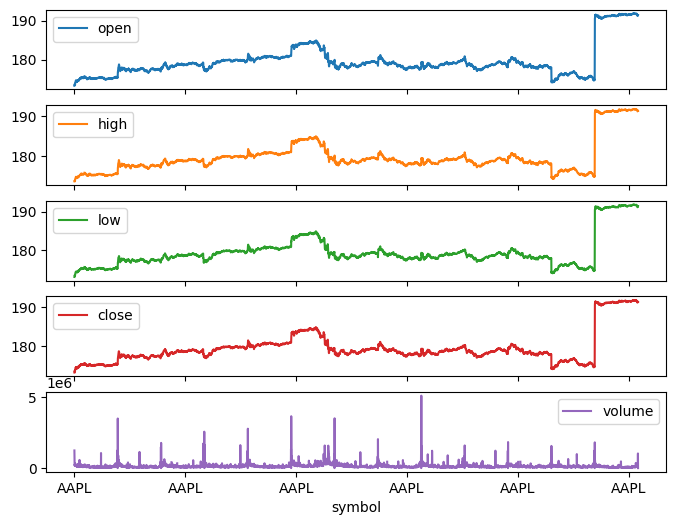

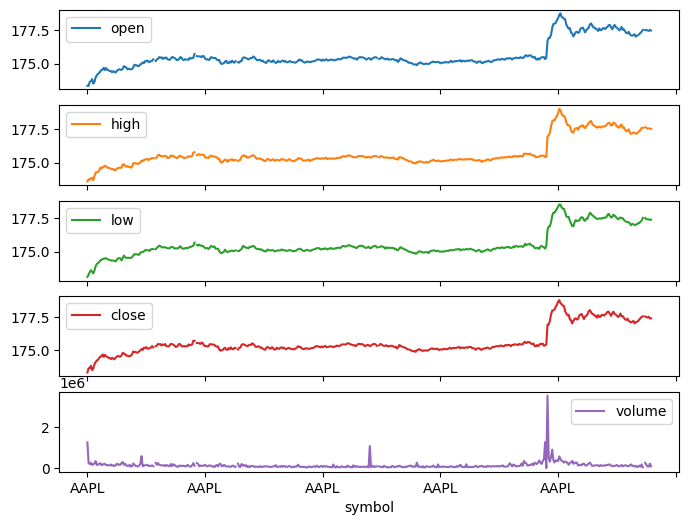

In [49]:
fig=plt.figure(figsize=(10,20))
date_time = df.xs('AAPL')['datetime']
plot_cols = ['open', 'high', 'low', 'close', 'volume'] # Use actual features
plot_features = df.xs('AAPL')[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df.xs('AAPL')[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True);

## ‚úÖ **T√¢che 5a: √âvaluer les mod√®les de baseline**

Nous utiliserons le dictionnaire suivant pour d√©finir les configurations de la fonction `hyperparameter_sweep()` pour diff√©rents mod√®les et observer leurs performances.

In [50]:
sweep_cfg = {
    'model_name': 'baseline-mean',
    "target": 'price actual',
    "col_offset": 1,
    "hp_name": 'window_size',
    "hp_values": [8,16,32,64],
    "metric": 'RMSE',
    "epochs": 50,
    "lr": 1e-3,
    "batch_size": 128,
    "test_bs": 256,
}

#Utiliser uniquement les prix des actions d'Apple Inc. pour les t√¢ches restantes.
df = df.xs('AAPL')

[1 point]

### üìå Q5.1 Modifiez le dictionnaire `sweep_cfg` pour obtenir les r√©sultats du mod√®le de baseline de la moyenne.


In [52]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-mean'
sweep_cfg['target'] = 'close'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  1.1757383
Best Window Size:  8


[1 point]

### üìå Q5.2 Modifiez le dictionnaire `sweep_cfg` pour obtenir les r√©sultats du mod√®le de baseline de la derni√®re valeur (last).


In [53]:
## Student TODO ##
sweep_cfg['model_name'] = 'baseline-last'
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  1.189271
Best Window Size:  8


## ‚úÖ **T√¢che 5b: Entrainer le mod√®le AR lin√©aire et r√©gler la taille de la fen√™tre**

[2 points]

### üìå Q5.3 Modifiez le dictionnaire sweep_cfg pour obtenir les r√©sultats du mod√®le AR lin√©aire et r√©gler pour le window_size optimal.

In [56]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-linear'
ARL_best_score, ARL_best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  0.05499443784356117
Best Window Size:  64


## ‚úÖ **T√¢che 5c: Entrainer le mod√®le AR MLP et ajuster la taille de la fen√™tre**

[2 points]

### üìå Q5.4 Modifiez le dictionnaire sweep_cfg pour obtenir les r√©sultats du mod√®le AR MP et r√©gler pour le window_size optimal.

In [57]:
## Student TODO ##
sweep_cfg['model_name'] = 'ar-mlp'
sweep_cfg['mlp_dim'] = 10
best_score, best_hp = hyperparameter_sweep(df, sweep_cfg)

(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
(5083,) -1.3238493e-06 1.0
Best Mean Squared Error:  0.0005616986309178174
Best Window Size:  8


## ‚úÖ **T√¢che 5d: Visualiser les pr√©dictions**

[3 points]

### üìå Q5.5 G√©n√©rez un graphique pour comparer visuellement les s√©ries temporelles de l'ensemble de test pr√©dites par le meilleur mod√®le et les s√©ries temporelles r√©elles.

(5083,) -1.3238493e-06 1.0
32/32 [==============================] - 0s 1ms/step


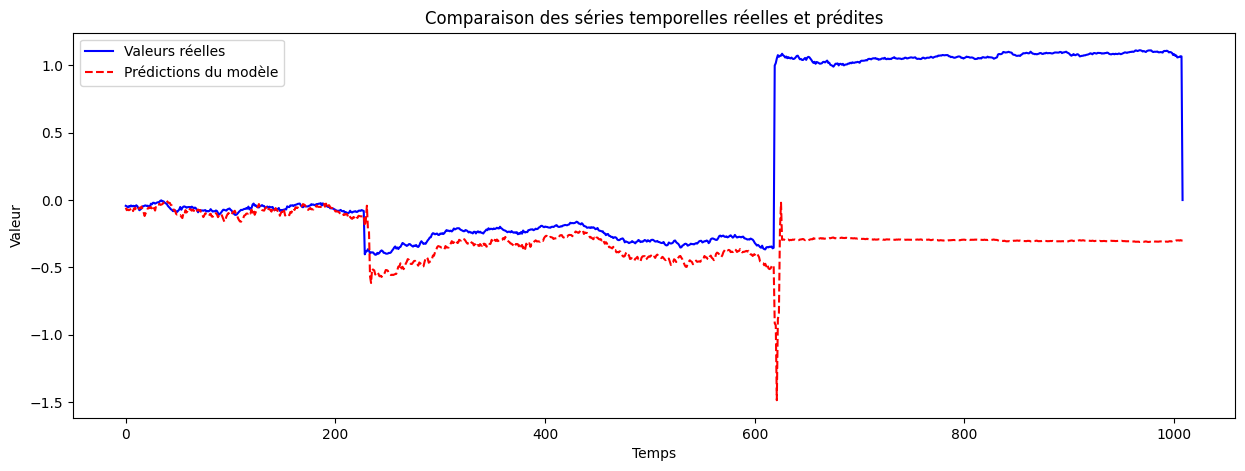

In [59]:
# Student TODO START
# Student TODO START
window_size = 8
mlp_dim = 10

# Pr√©traiter le jeu de donn√©es pour la meilleure taille de fen√™tre
data = preprocess_dataset(df, sweep_cfg['target'], lookback=window_size)

# D√©finir la taille de la fen√™tre dans sweep_cfg
sweep_cfg['window_size'] = window_size

# Pr√©parer les g√©n√©rateurs de donn√©es
_, _, test_generator = prepare_dataloaders(data, sweep_cfg)

# G√©n√©rer X_test et y_test en utilisant le test_generator
X_test = []
y_test = []
for batch in test_generator:
    X, y = batch
    X_test.append(X)
    y_test.append(y)

# Concat√©ner les r√©sultats si X_test et y_test sont des listes de batchs
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Charger le meilleur mod√®le ar-mlp avec les param√®tres optimis√©s
best_model = ar_mlp({'window_size': best_hp, 'mlp_dim': 10})
best_model.compile(optimizer=Adam(), loss='mean_squared_error')

# G√©n√©rez des pr√©dictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Cr√©er le graphique pour comparer les valeurs r√©elles et les pr√©dictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Valeurs r√©elles', color='blue')
plt.plot(y_pred, label='Pr√©dictions du mod√®le', color='red', linestyle='--')
plt.title('Comparaison des s√©ries temporelles r√©elles et pr√©dites')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

# Student TODO END

[3 points]

### üìå Q5.6 : Quel mod√®le fonctionne le mieux? Lequel est le pire? Donnez une explication de vos propres mots sur pourquoi vous observez cela.


<STUDENT_TODO_START>

\#STUDENT TODO

Le mod√®le ar_mlp est un mod√®le de r√©seau de neurones qui peut capturer des relations non lin√©aires complexes entre les points de donn√©es, ce qui est  b√©n√©fique dans notre s√©ries temporelles financi√®res puisqu'ils peuvent mieux saisir les motifs sous-jacents et les dynamiques de march√©.

Le mod√®le ar-linear, bien que performant, n'est pas aussi efficace pour saisir ces non-lin√©arit√©s, ce qui pourrait expliquer pourquoi il a un MSE plus √©lev√© que le mod√®le ar_mlp.

Les mod√®les de base baseline-mean et baseline-last sont  moins performants car ils sont tr√®s simplistes. Le baseline-mean pr√©dit simplement la moyenne des observations pass√©es, tandis que le baseline-last pr√©dit que la prochaine valeur sera identique √† la derni√®re observation. Ces mod√®les ne tiennent pas compte des structures plus complexes des donn√©es.


<STUDENT_TODO_END>